In [1]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel

import matplotlib.pyplot as plt

C:\Users\aleks\anaconda3\envs\causal_book_py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dowhy.__version__

'0.12'

# PSM Challenges
*Propensity Socres are not good for matching*


A part of [CausalPython](https://causalpython.io) series on causality.

<a href="https://causalpython.io"><img src="img/CausalPython.io__flat.png" width=150 align="left"></a>
<br>

## Get the data

In [3]:
SAMPLE_SIZE = 100000

# Process
W1 = np.random.normal(0, 1, SAMPLE_SIZE)
W2 = np.random.normal(0, 1, SAMPLE_SIZE)
T = np.clip(np.where(W1 > 1.96, 1, 0) + np.where(W2 > 1.96, 1, 0), 0, 1)
Y = 0.7*T + 1.5*W1 + 0.3*np.random.normal(0, 1, SAMPLE_SIZE)

df = pd.DataFrame(np.stack([W1, W2, T, Y]).T, columns=['W1', 'W2', 'T', 'Y'])

In [4]:
graph = """
graph [
    directed 1
    
    node [
        id "T" 
        label "T"
    ]    
    node [
        id "W1"
        label "W1"
    ]
    node [
        id "W2"
        label "W2"
    ]
    node [
        id "Y"
        label "Y"
    ]
    
    edge [
        source "W1"
        target "T"
    ]
    
    edge [
        source "W2"
        target "T"
    ]
    
    edge [
        source "W1"
        target "Y"
    ]
    
    edge [
        source "W2"
        target "Y"
    ]
    
    edge [
        source "T"
        target "Y"
    ]
]
"""

# Remove newlines
graph = graph.replace('\n', '')

In [5]:
# With graph
model = CausalModel(
    data=df,
    treatment='T',
    outcome='Y',
    graph=graph
)

<Figure size 100x100 with 0 Axes>

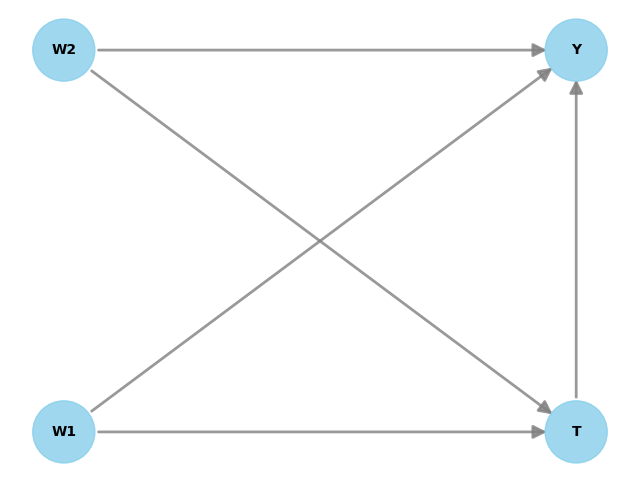

In [6]:
plt.figure(figsize=(1, 1))
model.view_model()
plt.show()

In [7]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d              
────(E[Y|W1,W2])
d[T]            
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,W1,W2,U) = P(Y|T,W1,W2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [11]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression',
    target_units='ate'
)

print(f'Estimate of causal effect (linear regression): {estimate.value}')

Estimate of causal effect (linear regression): 0.7080664819020028


C:\Users\aleks\anaconda3\envs\causal_book_py312\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [12]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_matching',
    target_units='ate'
)

print(f'Estimate of causal effect (PSM): {estimate.value}')

Estimate of causal effect (PSM): -1.3086956383147375
